# Recreate SPRING vizualisation of injury class 1  cells after regressing out the cell cycle
Save graph and auxiliary files to SPRING directory for interactive exploration.  
Allow the graph to fully relax using the browser version of force layout (empirically works best but slow).  
Save xy coordinates in SPRING (browser version).  
Load xy coordinates from the SPRING directory for further use within the notebook.

Inspired from here: https://nbviewer.jupyter.org/github/theislab/scanpy_usage/blob/master/180209_cell_cycle/cell_cycle.ipynb

In [1]:
import os,sys
import datetime

### Import scanpy

In [2]:
import scanpy.api as sc
sc.logging.print_versions()
sc.logging.print_memory_usage()
sc.settings.verbosity = 2

scanpy==1.3.4 anndata==0.6.13 numpy==1.15.4 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 
Memory usage: current 0.17 GB, difference +0.17 GB


### Import my utility functions and import statements from github

In [3]:
"""# This cell is run once to download my custom functions and import statements from github

!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions
    
# github doesn't seem to have an option to download a specific version of the repo from the history.
# So I download my utility functions and save the download time by appending it to the directory name.
# These utility functions to be shared together with the notebook.

toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
newname = "utility_functions_%s"%toappend
print(newname)


# rename the py file with utility functions
os.rename("utility_functions",newname)"""

'# This cell is run once to download my custom functions and import statements from github\n\n!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions\n    \n# github doesn\'t seem to have an option to download a specific version of the repo from the history.\n# So I download my utility functions and save the download time by appending it to the directory name.\n# These utility functions to be shared together with the notebook.\n\ntoappend = datetime.datetime.now().strftime(\'%y%m%d_%Hh%M\')\nnewname = "utility_functions_%s"%toappend\nprint(newname)\n\n\n# rename the py file with utility functions\nos.rename("utility_functions",newname)'

In [4]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_190425_11h32"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import
import rz_utility_spring as srz

python version: 3.6.7


## Load data and place into an annData object

In [5]:
!ls data_from_geo

cell_info_8594x25.tsv         injury_barcodes.tsv
control_barcodes.tsv          injury_genes.tsv
control_genes.tsv             injury_loom.loom
control_loom.loom             injury_matrix.mtx
control_matrix.mtx            raw_counts_8594x27998.mtx
gene_names_alphabetically.txt


In [6]:
obspath = 'data_from_geo/cell_info_8594x25.tsv'
countpath = 'data_from_geo/raw_counts_8594x27998.mtx'
genepath = 'data_from_geo/gene_names_alphabetically.txt'

In [7]:
# load cell info
obs = pd.read_csv(obspath,sep='\t',index_col=0)
print(obs.shape)
obs.head()

(8594, 25)


,barcode,condition,total_counts,pass_quality_filters,inj_epithelial,ctr_epithelial,excluded_as_immune_or_mesench,class,population,phase,...,x_control,y_control,x_class3_exploded,y_class3_exploded,x_control_injured,y_control_injured,x_class1_CTR_cell_cyc_removed,y_class1_CTR_cell_cyc_removed,x_class1_INJ_cell_cyc_removed,y_class1_INJ_cell_cyc_removed
0,AAACCTGAGTGCTGCC-1,control,2787,True,False,True,False,class3,ctr_DEEx,G1,...,783.705500,-377.074709,1082.172898,-266.303304,709.78614,-325.505019,NaN,NaN,NaN,NaN
1,AAACCTGAGTGGGTTG-1,control,3325,True,False,True,False,class3,ctr_upper_IEE,G1,...,709.612642,-429.409941,854.230866,-454.025809,529.15516,-471.961493,NaN,NaN,NaN,NaN
2,AAACCTGCAAGTCTAC-1,control,1781,False,False,False,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAACCTGCAATCTGCA-1,control,3468,True,False,False,True,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAACCTGCACGGTGTC-1,control,1745,False,False,False,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# load counts
adata = sc.read_mtx(countpath)
print(adata.shape)

# add genes (annotation of variables)
adata.var['genes'] = np.loadtxt(genepath,dtype=str)

# make sure var names are genes
adata.var_names = adata.var['genes'].values

# add obs (annotation of observations)
adata.obs = obs

# make sure index is unique AND a string
adata.obs_names_make_unique()
adata.obs_names = adata.obs_names.astype(str)

(8594, 27998)


## Download cell cycle gene list

In [9]:
#!mkdir -p Seurat_cell_cycle
# download cell cycles genes from here:
# https://www.dropbox.com/s/3dby3bjsaf5arrw/cell_cycle_vignette_files.zip?dl=1
# place into Seural_cell_cycle, unzip

ccpath = 'Seurat_cell_cycle/cell_cycle_vignette_files/regev_lab_cell_cycle_genes.txt'
cell_cycle_genes = np.loadtxt(ccpath,dtype='str')

print(len(cell_cycle_genes),len(set(cell_cycle_genes)))

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

97 97


### Human-to-mouse gene translation

In [10]:
# whoops, looks like these are human genes, and I have mouse data
# download a mouse-human orthology table fro mgi
# in general, for this purpose I want to be permissive

#opath = "http://www.informatics.jax.org/downloads/reports/HMD_HumanPhenotype.rpt"
#toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
#!mkdir mouse_human_orthologs
#!cd mouse_human_orthologs && curl -LO $opath
#!echo "Downloaded from $opath \n on $toappend" > mouse_human_orthologs/readme.txt

In [11]:
oframe = pd.read_csv('mouse_human_orthologs/HMD_HumanPhenotype.rpt',sep='\t',header=None)

# human to mouse dictionary
h2m = {}
for h,m in zip(oframe[0],oframe[4]):
    if h not in h2m:
        h2m[h] = []
    h2m[h] = h2m[h]+[m]

    
# translate s_genes
# check the length before
print(len(s_genes))

# translate
s_genes = [h2m[i] for i in s_genes if i in h2m]
print(len(s_genes)) # if fewer, some human genes were not in the dictionary

# flatten
s_genes = rz.flatten_list_of_lists(s_genes)
print(len(s_genes))

# make sure no gene names repeated after translation
s_genes = rz.oset(s_genes)
print(len(s_genes))

# same with g2m_genes
g2m_genes = [h2m[i] for i in g2m_genes if i in h2m]
print(len(g2m_genes)) # if fewer, some human genes were not in the dictionary

# flatten
g2m_genes = rz.flatten_list_of_lists(g2m_genes)
print(len(g2m_genes))

# make sure no gene names repeated after translation
g2m_genes = rz.oset(g2m_genes)
print(len(g2m_genes))

# overwrite cell cycle genes
cell_cycle_genes = s_genes + g2m_genes
print(len(cell_cycle_genes))
cell_cycle_genes = rz.oset(cell_cycle_genes)
print(len(cell_cycle_genes))

43
42
42
42
52
52
52
94
94


## Select cells and regress out cell cycle

In [12]:
# select cells
cell_mask = adata.obs['inj_epithelial'].astype(bool).values&\
            (adata.obs['class'] == 'class1').values
print(cell_mask.sum())

2482


In [13]:
# make a copy of adata only focusing on cells of interest
cdata = adata[cell_mask,:].copy()

# filter out genes with zero counts
min_non_zero = cdata.X.data.min()
sc.pp.filter_genes(cdata,min_counts=min_non_zero)

# scale to 1e4 total counts. 
sc.pp.normalize_per_cell(cdata, counts_per_cell_after=1e4)

# save a copy of data before taking the log:
cdata.uns['X_lin_cptt'] = cdata.X.copy() # for X linear counts-per-10-thousand

# log transform
sc.pp.log1p(cdata)

# zscore
sc.pp.scale(cdata)

# keep a copy of the data before regressing out cell cycle:
cdata.uns['X_log_z'] = cdata.X.copy() # for log transformed and zscored

filtered out 10992 genes that are detected in less than 1.0 counts


In [14]:
# make sure to only leave those cell cycle genes I have in the reduced dataset
print(len(s_genes),len(g2m_genes),len(cell_cycle_genes))
s_genes = [i for i in s_genes if i in cdata.var_names]
g2m_genes = [i for i in g2m_genes if i in cdata.var_names]
cell_cycle_genes = [i for i in cell_cycle_genes if i in cdata.var_names]
print(len(s_genes),len(g2m_genes),len(cell_cycle_genes))

42 52 94
42 52 94


In [15]:
# score cell cycle
sc.tl.score_genes_cell_cycle(cdata, s_genes=s_genes, g2m_genes=g2m_genes, random_state=1)

calculating cell cycle phase
computing score 'S_score'
    finished (0:00:01.09)
computing score 'G2M_score'
    finished (0:00:01.08)


Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.


... storing 'condition' as categorical
... storing 'class' as categorical
... storing 'population' as categorical
... storing 'phase' as categorical
... storing 'source_sink_for_pseudotime' as categorical
... storing 'class2_3_like' as categorical
/Users/rapolaszilionis/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/rapolaszilionis/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


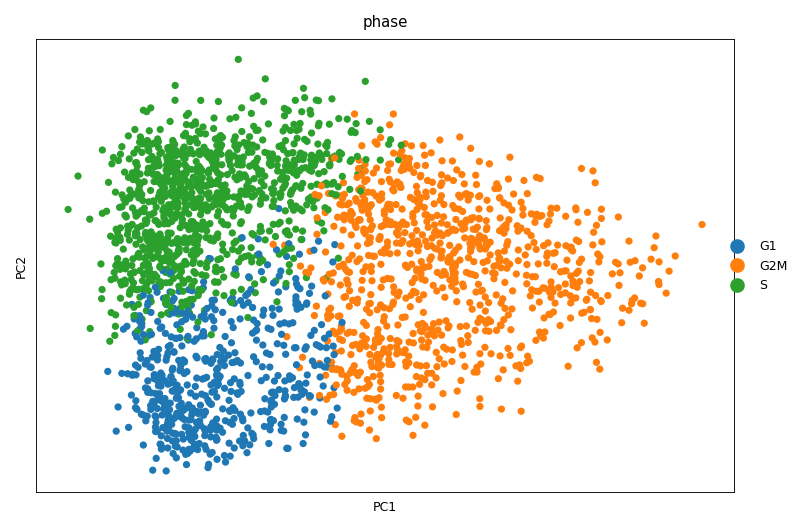

In [16]:
# plot a PC1 vs PC2, which PCA calculated using cell-cycle genes only
cdata_cc_genes = cdata[:, cell_cycle_genes]
sc.tl.pca(cdata_cc_genes)
sc.pl.pca_scatter(cdata_cc_genes, color='phase')

... storing 'condition' as categorical
... storing 'class' as categorical
... storing 'population' as categorical
... storing 'phase' as categorical
... storing 'source_sink_for_pseudotime' as categorical
... storing 'class2_3_like' as categorical


regressing out ['S_score', 'G2M_score']
    finished (0:00:58.86)
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.


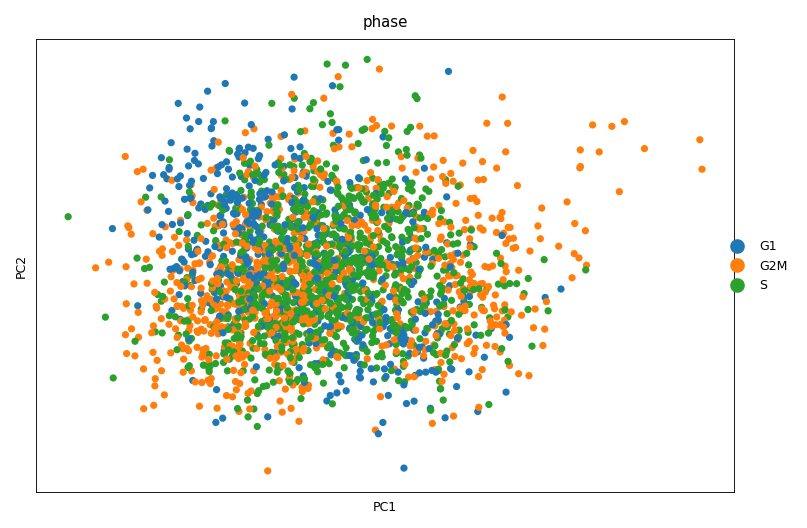

In [17]:
sc.pp.regress_out(cdata, ['S_score', 'G2M_score'])
sc.pp.scale(cdata)

cdata_cc_genes = cdata[:, cell_cycle_genes]
sc.tl.pca(cdata_cc_genes)
sc.pl.pca_scatter(cdata_cc_genes, color='phase')

## Preprocess for SPRING

In [22]:
project_dir = "SPRING_dev-master/datasets/Sharir_et_al_2019/"

In [23]:
# chose a name for the spring subplot
plot_name = 'injury_class1_no_cc'

# chose dataset for selecting abundant and variable genes
# here I use linear counts-per-10k

E = cdata.uns["X_lin_cptt"]

# in an attempt to be more organized I keep a log of spring parameter and intermediate data structures used in
# the form of an unstructured annotation as part of an AnnData object.
srz.start_spring_params(cdata,plot_name)

# print the newly created dictionary, also define a variable to access it faster:
pdict = cdata.uns['spring_params'][plot_name]
pdict

{'k': 5,
 'cell_mask': array([ True,  True,  True, ...,  True,  True,  True]),
 'min_counts': 3,
 'min_cells': 3,
 'base_ix': array([   0,    1,    2, ..., 2479, 2480, 2481]),
 'num_pc': 20,
 'plot_name': 'injury_class1_no_cc'}

In [24]:
# overwrite some of the parameters for SPRING
pdict = cdata.uns['spring_params'][plot_name]
pdict['cell_mask'] = cell_mask # record which cell out of all were used
pdict['k'] = 5
pdict['min_counts'] = 5
pdict['min_cells'] = 3
pdict

{'k': 5,
 'cell_mask': array([False, False, False, ..., False, False, False]),
 'min_counts': 5,
 'min_cells': 3,
 'base_ix': array([   0,    1,    2, ..., 2479, 2480, 2481]),
 'num_pc': 20,
 'plot_name': 'injury_class1_no_cc'}

### Filter genes

In [25]:
# avoid genes starting with
toavoid = ['mt-','Rps','Rpl','Mrpl','Mrps']

# genes to exclude:
exclude_gene_names = []
for j in toavoid:
    exclude_gene_names.append([i for i in adata.var['genes'] if i.startswith(j)])
exclude_gene_names = rz.flatten_list_of_lists(exclude_gene_names)

pdict['gene_names_excluded'] = exclude_gene_names
print('%d genes excluded based on name'%len(exclude_gene_names))

203 genes excluded based on name


In [26]:
# filter on abundance:
pdict['abundant_gene_mask'] = srz.filter_abund_genes(
                                                     E,
                                                     pdict['min_counts'],
                                                     pdict['min_cells']
                                                    )

6722 genes passing abundance filter


In [27]:
# calculate v score (Klein et al., 2015, see equation S4 and S13)
pdict['v_score_dict'] = srz.vscores(E)

179 and 181 genes excluded as correlated to s and g2m scores, respectively


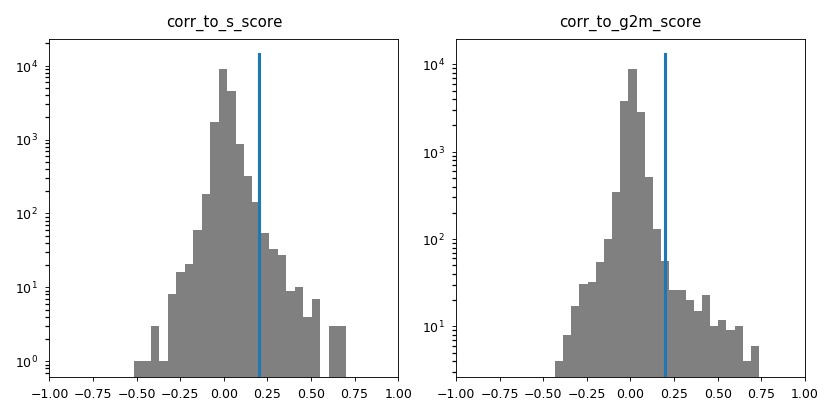

In [28]:
# if regressing out cell cycle, also remove genes correlated to cell cycle scores
# those scores there calculated on log transformed counts-per-10k+1 data
# use the same to calculate correlation
data = cdata.uns["X_log_z"]

# get correlation to s and g2m scores:
score = cdata.obs['S_score'].values
cdata.var['corr_to_s_score'] = rz.pearsonr(score,data.T).flatten()

score = cdata.obs['G2M_score'].values
cdata.var['corr_to_g2m_score'] = rz.pearsonr(score,data.T).flatten()

# exclude genes with positive correlation to cell cycle score above a chosen threshold:
ts = 0.2
pdict['corr_to_cell_cyc_threshold'] = ts

# get names of gene too correlated to cell cycle
pdict['genes_corr_to_s_score'] = cdata.var_names[cdata.var['corr_to_s_score']>ts]
pdict['genes_corr_to_g2m_score'] = cdata.var_names[cdata.var['corr_to_g2m_score']>ts]
print('%d and %d genes excluded as correlated to s and g2m scores, respectively'%(
                                                        len(pdict['genes_corr_to_s_score']),
                                                        len(pdict['genes_corr_to_g2m_score'])))

# plot a a histogram of pearson r values:
fig,gs = rz.startfig(14,7,columns=2,return_first_ax=False)

for nr,lab in enumerate(['corr_to_s_score','corr_to_g2m_score']):
    a = fig.add_subplot(gs[0,nr])
    a.hist(cdata.var[lab],lw=0,bins=25,color='0.5')
    a.set_title(lab);
    a.set_yscale('log')
    a.set_xlim(-1,1)
    a.plot((ts,ts),(0,a.get_ylim()[1]))
gs.tight_layout(fig)

In [29]:
# combine gene filters so far:
undesired = list(pdict['gene_names_excluded'])+\
            list(pdict['genes_corr_to_s_score'])+\
            list(pdict['genes_corr_to_g2m_score'])+\
            list(cdata.var_names[~pdict['abundant_gene_mask']])

print(len(undesired))
undesired = list(set(undesired))
print(len(undesired))

# boolean mask
combmask = ~np.in1d(cdata.var_names,undesired)
print(combmask.sum(),'surviving genes so far')

10847
10796
6212 surviving genes so far


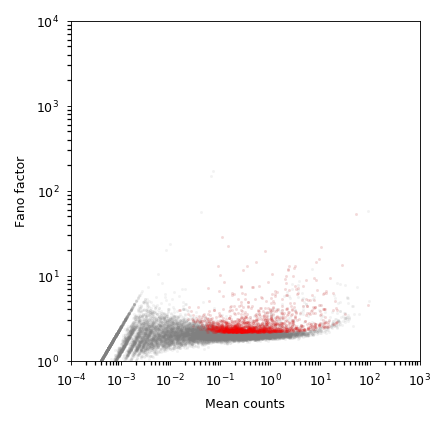

In [30]:
# out of the surviving genes, select a fix number of most variable ones:
nrvar = 2000
pdict['nr_var_genes'] = nrvar

# place v score and gene names into a temporary pd.Series for convenience:
v = pd.Series(pdict['v_score_dict']['v_scores'],index=cdata.var_names)

# apply filter so far:
v = v[combmask]

# get the names of the most variable genes:
pdict['genes_used'] = v.sort_values(ascending=False)[:nrvar].index


# plot a v score vs mean plot with genes used further colored in red
ff = pdict['v_score_dict']['ff_gene']
mu = pdict['v_score_dict']['mu_gene']
finalmask = np.in1d(cdata.var_names,pdict['genes_used'])



# check scatter
s = 2
plt.figure(figsize=(3,3))
plt.scatter(mu,ff,lw=0,color='0.5',alpha=0.1,s=s)
plt.scatter(mu[finalmask],ff[finalmask],lw=0,color='r',alpha=0.1,s=s)
plt.xscale('log');
plt.yscale('log');
plt.xlim(0.0001,1000)
plt.ylim(1,10000)
plt.xlabel('Mean counts')
plt.ylabel('Fano factor');

### Prepare data for PCA

In [31]:
# use zscore after regressin out cell cycle
Z = cdata[:,pdict['genes_used']].X.copy()

# find the number of non-random PCs
d = srz.find_num_pc(Z,start_pc=50,sparse=False)

# record results to log:
pdict['num_pc'] = d['num_pc']
pdict['eigenvectors'] = d['pca'].components_
pdict['eigenvalues'] = d['pca'].explained_variance_


print(d['num_pc'])

calculating the first 50 observed eigenvalues...
calculating the random eigenvalues for 10 rounds of shuffling...
1 	 34 	 0.02 min.
calculating the first 100 observed eigenvalues...
calculating the random eigenvalues for 10 rounds of shuffling...
2 	 37 	 0.05 min.
3 	 35 	 0.07 min.
4 	 36 	 0.09 min.
5 	 36 	 0.11 min.
6 	 37 	 0.13 min.
7 	 35 	 0.15 min.
8 	 36 	 0.16 min.
9 	 36 	 0.19 min.
10 	 36 	 0.21 min.
35


In [32]:
# apply dimensionality reduction on Z (get principle components)
# note, that eigenvalues are calculated base_ix only
# make sure to provide a dense matrix Z

P = pdict['eigenvectors'][:pdict['num_pc'],:].dot(Z.T).T
print(P.shape)

(2482, 35)


In [33]:
# create a temporary AnnData object to be able to use standard scanpy functions:
P = sc.AnnData(P)

# get kNN graph
# ignore the error message: https://github.com/lmcinnes/umap/issues/87
k = pdict['k']
print(k, 'neighbors')
sc.pp.neighbors(P,k,use_rep='X')

# draw force-directed graph
sc.tl.draw_graph(P, layout='fa')

5 neighbors
computing neighbors


/Users/rapolaszilionis/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


    finished (0:00:03.40)
drawing single-cell graph using layout "fa"
    finished (0:00:10.42)


In [34]:
# continuous per-cell metadata
contvars = ['total_counts']

# categorical
catvars = ['condition','class','population','phase','class2_3_like']

In [35]:
# export_spring_plot was complaining about the data format, force the right one
for contvar in contvars:
    P.obs[contvar] = cdata.obs[contvar].astype(float).values
    
for catvar in catvars:
    P.obs[catvar] = cdata.obs[catvar].astype(str).values

In [36]:
plot_name = pdict['plot_name']
print(plot_name)
srz.export_spring_plot(P,
                       project_dir,
                       plot_name,
                       
                       # specify the normalized expression values
                       # this is solely to calculate where the default saturation
                       # of gene expression is in the interactive explorer
                       E = adata[cell_mask].X.tocsc(), # tocsc() super important here
                       gene_list = adata.var_names.values,
                       cell_groupings=catvars,
                       custom_color_tracks=contvars,
                      )

injury_class1_no_cc
Writing subplot to SPRING_dev-master/datasets/Sharir_et_al_2019/injury_class1_no_cc/


In [37]:
# the function "srz.export_spring_plot" needs to be updated to properly save the cell filter. To do.
# for now I use a hack and save manually using the code in this cell.

subplot_dir = project_dir+'/'+plot_name + '/'
cell_ix = np.arange(len(pdict['cell_mask']))[pdict['cell_mask']]  
np.savetxt(subplot_dir + 'cell_filter.txt', cell_ix, fmt='%i')
np.save(subplot_dir + 'cell_filter.npy', cell_ix)

In [38]:
#save plot parameters
rz.save_stuff(path=project_dir+'/'+plot_name+'/params',stuff=pdict)

# Example of interacting with SPRING colortracks back and forth: change colors of classes

In [39]:
cg = srz.read_cell_groupings(project_dir+plot_name+'/categorical_coloring_data.json')
catcolors = {key:value['label_list'] for key,value in cg.items()}
color_dict = {key:value['label_colors'] for key,value in cg.items()}

# overwrite colors as desired
color_dict['population'] = {
'ctr_AMB_dist': '#cdceca',
'inj_AMB_dist': '#cdceca',
'ctr_AMB_prox': '#a0a2a1',
'inj_AMB_prox': '#a0a2a1',
'ctr_G2_M': '#344683',
'inj_G2_M': '#344683',
'ctr_OSR': '#b9938f',
'inj_OSR': '#b9938f',
'ctr_M_G1': '#607dac',
'inj_M_G1': '#607dac',
'ctr_ISR_SI': '#eb4034',
'inj_ISR_SI': '#eb4034',
'ctr_S': '#a8bad4',
'inj_S': '#a8bad4',
'ctr_SI': '#513230',
'inj_SI': '#513230',
'ctr_OEE_1': '#eddd00',
'inj_OEE_1': '#eddd00',
'ctr_DEEx': '#948f35',
'inj_DEEx': '#948f35',
'ctr_OEE_2': '#df9445',
'inj_OEE_2': '#df9445',
'ctr_pre_AMB': '#6c6d6a',
'inj_pre_AMB': '#6c6d6a',
'ctr_upper_IEE': '#302651',
'inj_upper_IEE': '#302651',
'ctr_OEE_IEE': '#a64a03',
'inj_OEE_IEE': '#a64a03',
'ctr_VEE': '#773579',
'inj_VEE': '#773579'}

color_dict['class'] = {
    'class1':'#21267f',
    'class2':'#666666',
    'class3':'#b2361f'
}


color_dict['class2_3_like'] = {
'ctr_AMB_dist_like': '#cdceca',
'ctr_AMB_prox_like': '#a0a2a1',
'ctr_G2_M_like': '#344683',
'ctr_OSR_like': '#b9938f',
'ctr_M_G1_like': '#607dac',
'ctr_ISR_SI_like': '#eb4034',
'ctr_S_like': '#a8bad4',
'ctr_SI_like': '#513230',
'ctr_OEE_1_like': '#eddd00',
'ctr_DEEx_like': '#948f35',
'ctr_OEE_2_like': '#df9445',
'ctr_pre_AMB_like': '#6c6d6a',
'ctr_upper_IEE_like': '#302651',
'ctr_OEE_IEE_like': '#a64a03',
'ctr_VEE_like': '#773579'
}

srz.overwrite_cell_groupings(project_dir+plot_name,catcolors,colordd=color_dict)

# Load coordinates and plot scatter

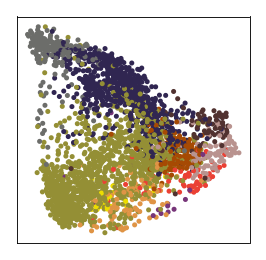

In [40]:
xy = pd.read_csv(project_dir+plot_name+'/coordinates.txt',header=None, index_col=0)
x = xy[1]
y = -xy[2] # y is flipped for some reason

plt.figure(figsize=(2,2))

color = [color_dict['class2_3_like'][i] for i in catcolors['class2_3_like']]

plt.scatter(x,y,color=color,s=2)
plt.xticks([])
plt.yticks([])
plt.show()